In [1]:
"""Noise generators for long streams of 1/f^alpha noise.

The time domain methods used here follow Stephane Plaszczynski, Fluct.
Noise Lett. 7: R-R13, 2007. DOI: 10.1142/S0219477507003635, see also
https://arxiv.org/abs/astro-ph/0510081. The code sticks to the notation
in this article (which is different to the SciPy docs).

Examples and documentation are available on GitHub:
https://github.com/janwaldmann/pyplnoise
"""

from typing import List, Optional, Tuple

import numpy as np
from scipy import signal


class WhiteNoise:
    """White noise generator (constant power spectrum)."""

    @property
    def fs(self) -> float:
        """Get the sampling frequency."""
        return self._fs

    @property
    def rms(self) -> float:
        """Get the noise signal RMS value."""
        return self._rms

    def __init__(self,
                 f_sample: float,
                 psd: float = 1.,
                 seed: Optional[int] = None) -> None:
        """Create a WhiteNoise instance.

        Args:
            f_sample: sampling frequency in Hz.
            psd: constant value of the two-sided power
                spectral density. The RMS value of the generated noise
                is sqrt(f_sample x psd).
            seed: seed for the random number generator. If none is provided,
                entropy from the system will be used.
        """
        self._fs = f_sample
        self._rms = np.sqrt(f_sample * psd)
        self._rng = np.random.default_rng(seed)

    def get_sample(self) -> float:
        """Retrieve a single sample."""
        return self._rng.normal(loc=0., scale=self.rms)

    def get_series(self, npts: int) -> np.ndarray:
        """Retrieve an array of npts samples."""
        if npts > np.iinfo(int).max:
            raise ValueError("""Argument 'npts' must be an integer <= {}.
If you want to obtain more samples, run get_series() several times and
concatenate the results.""".format(np.iinfo(int).max))
        return self._rng.normal(loc=0., scale=self.rms, size=npts)


class RedNoise:
    """Red (Brownian) noise generator (1/f^2 power spectrum).

    The two-sided power spectral density (PSD) is scaled such that
    PSD(f = 1 Hz) = 1. Below f_min, the noise is white.
    """

    @property
    def fs(self) -> float:
        """Get the sampling rate."""
        return self._fs

    @property
    def fmin(self) -> float:
        """Get the lower cutoff frequency."""
        return self._fmin

    def __init__(self,
                 f_sample: float,
                 f_min: float,
                 init_filter: bool = True,
                 seed: Optional[int] = None) -> None:
        """Create a RedNoise instance.

        Args:
            f_sample: sampling frequency in Hz.
            f_min: frequency cutoff in Hz. Below f_min, the noise
                will be white.
            init_filter: settle filter during object initialization. This
                might take some time depending on the magnitude of the
                ratio f_sample/f_min. Default and highly recommended: True.
            seed: seed for the random number generator. If none is
                provided, entropy from the system will be used.

        """
        self._fs = f_sample
        self._fmin = f_min
        self._whitenoise = WhiteNoise(self.fs, psd=1., seed=seed)
        self._scaling = 1. / (self.fs * self.fmin)
        self._a = np.array([2. * np.pi * self.fmin])
        self._b = np.array(
            [1., -1. * np.exp(-2. * np.pi * self.fmin / self.fs)])
        self._zi = signal.lfilter_zi(self._a,
                                     self._b) * self._whitenoise.get_sample()
        if init_filter:
            npts_req = np.ceil(2. * self.fs / self.fmin)
            # safeguard for machines with small memory
            npts_per_run_max = 150000000
            if npts_req > npts_per_run_max:
                for i in range(
                        np.ceil(npts_req / npts_per_run_max).astype(int)):
                    _ = self.get_series(npts_per_run_max)
            else:
                _ = self.get_series(int(npts_req))

    def get_sample(self) -> np.float64:
        """Retrieve a single sample."""
        sample, self._zi = signal.lfilter(self._a,
                                          self._b,
                                          np.array(
                                              [self._whitenoise.get_sample()]),
                                          zi=self._zi)
        return sample[0] * self._scaling

    def get_series(self, npts: int) -> np.ndarray:
        """Retrieve an array of npts samples."""
        if npts > np.iinfo(int).max:
            raise ValueError("""Argument 'npts' must be an integer <= {}.
If you want to obtain more samples, run get_series() several times and
concatenate the results.""".format(np.iinfo(int).max))
        samples, self._zi = signal.lfilter(self._a,
                                           self._b,
                                           self._whitenoise.get_series(npts),
                                           zi=self._zi)
        return samples * self._scaling


class AlphaNoise:
    """Colored noise noise generator (arbitrary 1/f^alpha power spectrum).

    The two-sided power spectral density (PSD) is scaled such that
    PSD(f = 1 Hz) = 1. The noise generator has user-specified lower and
    upper cutoff frequencies. Below and above these frequencies, the
    generated noise is white.
    """

    @property
    def fs(self) -> float:
        """Get the sampling rate."""
        return self._fs

    @property
    def fmin(self) -> float:
        """Get the lower cutoff frequency."""
        return self._fmin

    @property
    def fmax(self) -> float:
        """Get the upper cutoff frequency."""
        return self._fmax

    @property
    def alpha(self) -> float:
        """Get the exponent of the 1/f^alpha power spectrum."""
        return self._alpha

    def __init__(self,
                 f_sample: float,
                 f_min: float,
                 f_max: float,
                 alpha: float,
                 init_filter: bool = True,
                 seed: Optional[int] = None) -> None:
        """Create an AlphaNoise instance.

        Args:
            f_sample: sampling frequency in Hz.
            f_min: lower frequency cutoff in Hz. Below f_min, the noise
                will be white.
            f_max: upper frequency cutoff in Hz. Above f_max, the noise
                will be white.
            alpha: exponent of the 1/f^alpha power spectrum. Must be in the
                interval [0.01, 2.0].
            init_filter: settle filter during object initialization. This
                might take some time depending on the magnitude of the
                ratio f_sample/f_min. Default and highly recommended: True.
            seed: seed for the random number generator. If none is
                provided, entropy from the system will be used.
        """
        if alpha > 2. or alpha < 0.01:
            raise ValueError(
                "The exponent must be in the range 0.01 <= alpha <= 2.")
        if f_sample < 2. * f_max:
            raise ValueError(
                "The sampling rate must be at least 2 x f_max (= {}).".format(
                    2. * f_max))
        self._fs = f_sample
        self._fmin = f_min
        self._fmax = f_max
        self._alpha = alpha
        self._whitenoise = WhiteNoise(self.fs, psd=1., seed=seed)
        log_w_min = np.log10(2. * np.pi * self.fmin)
        log_w_max = np.log10(2. * np.pi * self.fmax)
        self._num_spectra = np.ceil(4.5 * (log_w_max - log_w_min)).astype(int)
        dp = (log_w_max - log_w_min) / self._num_spectra
        self._a: List[np.ndarray] = [None] * self._num_spectra
        self._b: List[np.ndarray] = [None] * self._num_spectra
        self._zi: List[np.ndarray] = [None] * self._num_spectra
        for i in range(0, self._num_spectra):
            log_p_i = log_w_min + dp * 0.5 * ((2. * i + 1.) - self.alpha / 2.)
            filter_f_min = np.power(10., log_p_i) / (2. * np.pi)
            filter_f_max = np.power(10., log_p_i +
                                    (dp * self.alpha / 2.)) / (2. * np.pi)
            if i == 0:
                self._fmin = filter_f_min
            a0, a1, b1 = self._calc_filter_coeff(filter_f_min, filter_f_max)
            self._a[i] = np.array([a0, a1])
            self._b[i] = np.array([1., -1. * b1])
            self._zi[i] = signal.lfilter_zi(self._a[i], self._b[i])
        self._fmax = filter_f_max
        self._scaling = 1. / np.power(self.fmax, self.alpha / 2.)
        if init_filter:
            npts_req = np.ceil(2. * self.fs / self.fmin)
            # safeguard for machines with small memory
            npts_per_run_max = 150000000
            if npts_req > npts_per_run_max:
                for i in range(
                        np.ceil(npts_req / npts_per_run_max).astype(int)):
                    _ = self.get_series(npts_per_run_max)
            else:
                _ = self.get_series(int(npts_req))

    def get_sample(self) -> np.float64:
        """Retrieve a single sample."""
        sample = np.array([self._whitenoise.get_sample()])
        for i in range(0, self._num_spectra):
            sample, self._zi[i] = signal.lfilter(self._a[i],
                                                 self._b[i],
                                                 sample,
                                                 zi=self._zi[i])
        return sample[0] * self._scaling

    def get_series(self, npts: int) -> np.ndarray:
        """Retrieve an array of npts samples."""
        if npts > np.iinfo(int).max:
            raise ValueError("""Argument 'npts' must be an integer <= {}.
If you want to obtain more samples, run get_series() several times and
concatenate the results.""".format(np.iinfo(int).max))
        samples = self._whitenoise.get_series(npts)
        for i in range(0, self._num_spectra):
            samples, self._zi[i] = signal.lfilter(self._a[i],
                                                  self._b[i],
                                                  samples,
                                                  zi=self._zi[i])
        return samples * self._scaling

    def _calc_filter_coeff(self, f_min: float,
                           f_max: float) -> Tuple[float, float, float]:
        a0 = (self.fs + f_max * np.pi) / (self.fs + f_min * np.pi)
        a1 = -1. * (self.fs - f_max * np.pi) / (self.fs + f_min * np.pi)
        b1 = (self.fs - f_min * np.pi) / (self.fs + f_min * np.pi)
        return (a0, a1, b1)


class PinkNoise(AlphaNoise):
    """Pink noise generator (1/f power spectrum)."""

    @property
    def fs(self) -> float:
        """Get the sampling rate."""
        return self._fs

    @property
    def fmin(self) -> float:
        """Get the lower cutoff frequency."""
        return self._fmin

    @property
    def fmax(self) -> float:
        """Get the upper cutoff frequency."""
        return self._fmax

    def __init__(self,
                 f_sample: float,
                 f_min: float,
                 f_max: float,
                 init_filter: bool = True,
                 seed: Optional[int] = None) -> None:
        """Create a PinkNoise instance."""
        self._fs = f_sample
        self._fmin = f_min
        self._fmax = f_max
        AlphaNoise.__init__(self, f_sample, f_min, f_max, 1., init_filter,
                            seed)

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


fs = 10.
npts = 7000
t = np.linspace(0., npts/fs, num=npts)

N = 5e-3 # °/sqrt(s) = 0.3 °/sqrt(h)
B = 7e-4 # °/s = 2.5 °/h
K = 6e-3 # °/s/sqrt(s)


whnoise = WhiteNoise(fs)
rdnoise = RedNoise(fs, 1e-8)
pknoise = PinkNoise(fs, 1e-6, fs/2.)

w = N * whnoise.get_series(npts) + B / np.sqrt(2. * np.pi) * pknoise.get_series(npts) +\
K / (2. * np.pi) * rdnoise.get_series(npts)

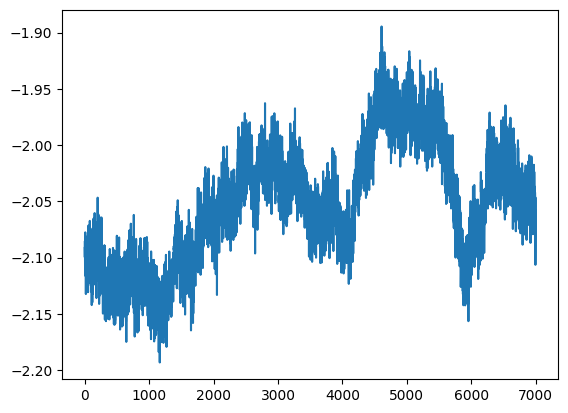

In [3]:
import matplotlib.pyplot as plt

plt.plot(w)

In [4]:
# Allan Variance Tools

# Author: Nikolay Mayorov <nikolay.mayorov@zoho.com>

from __future__ import division
import numpy as np
import pandas as pd
from scipy.optimize import nnls





In [5]:
import matplotlib.pyplot as plt
from firefly.math import allan_variance

def generate_time_array(fs, N):
    """
    Generate a time array based on the sampling frequency and number of points.

    Parameters:
    - fs: Sampling frequency in Hz
    - N: Number of points

    Returns:
    - time_array: NumPy array representing the time values
    """
    time_array = np.arange(N) / fs
    return time_array


<Axes: xlabel='Averaging time $\\tau$, s', ylabel='Allan deviation, unit'>

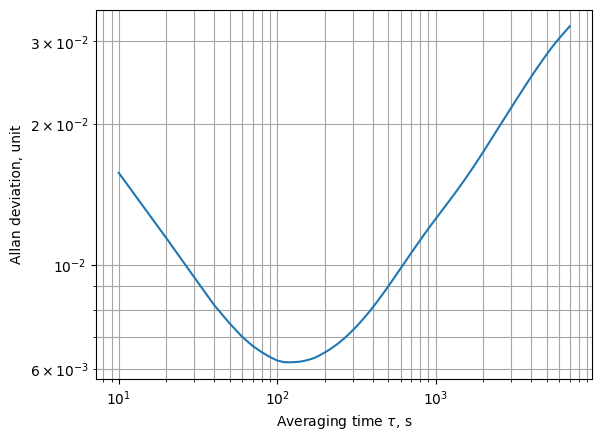

In [6]:
from firefly.math import plot_allan_deviation,allan_variance
(tau,ad) = allan_variance(w,fs)
plot_allan_deviation(tau,ad)

In [7]:
params, av_pred = params_from_avar(tau, ad,effects=["white","flicker","walk"])
params



NameError: name 'params_from_avar' is not defined

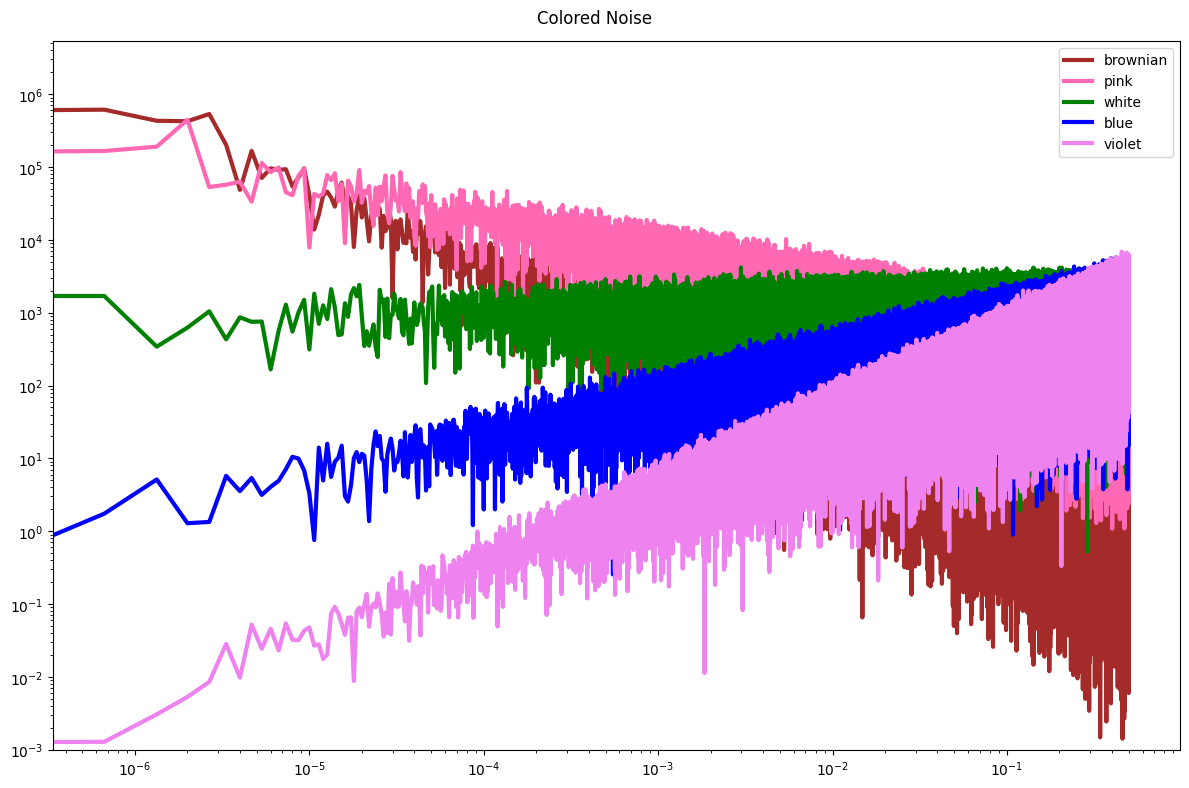

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    return plt.loglog(f, np.abs(np.fft.rfft(s)))[0]

def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N))
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S
        return np.fft.irfft(X_shaped)

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f)

@PSDGenerator
def violet_noise(f):
    return f

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

plt.figure(figsize=(12, 8), tight_layout=True)
for G, c in zip(
        [brownian_noise, pink_noise, white_noise, blue_noise, violet_noise], 
        ['brown', 'hotpink', 'green', 'blue', 'violet']):
    plot_spectrum(G(30*50_000)).set(color=c, linewidth=3)
plt.legend(['brownian', 'pink', 'white', 'blue', 'violet'])
plt.suptitle("Colored Noise");
plt.ylim([1e-3, None]);

0.9999317937999823


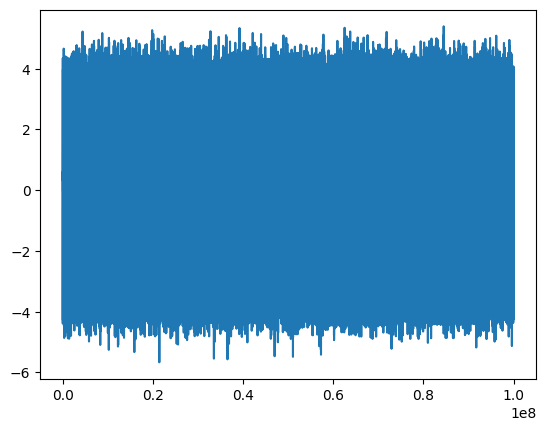

In [ ]:


x = white_noise(100000000)
plt.plot(x)
print(np.std(x))

0.999998455502112


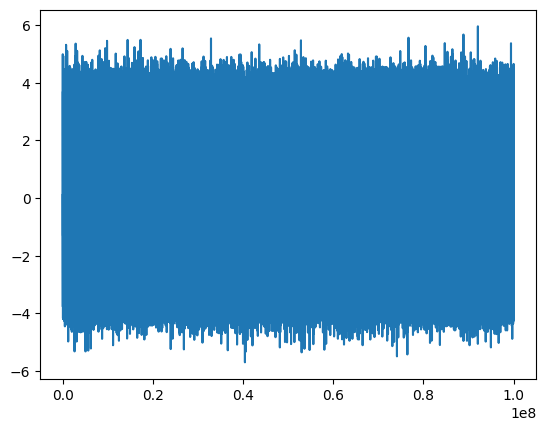

In [ ]:
x = WhiteNoise(1).get_series(100000000)
plt.plot(x)
print(np.std(x))

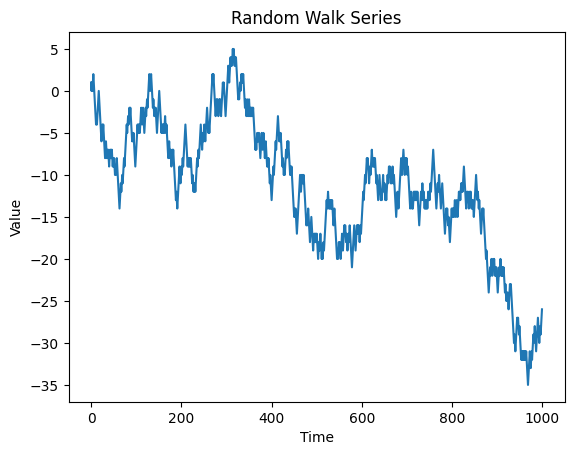

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of steps and the initial value
num_steps = 1000
initial_value = 0

# Generate random steps
steps = np.random.choice([-1, 1], size=num_steps)

# Calculate the cumulative sum of the steps
cumulative_sum = np.cumsum(steps)

# Generate the random walk series
series = initial_value + cumulative_sum

# Plot the series
plt.plot(series)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Random Walk Series')
plt.show()


In [ ]:
import numpy as np

def generate_random_walk(n):
    white_noise = np.random.randn(n)
    random_walk = np.cumsum(white_noise)
    return random_walk


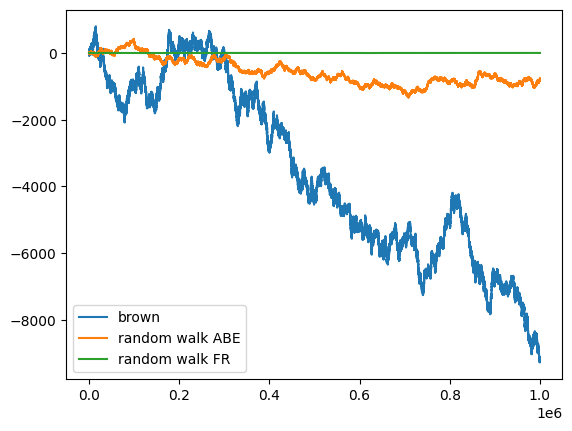

In [11]:
from firefly.math.noise import random_walk
import matplotlib.pyplot as plt
from allantools import noise

N = 1000000

plt.plot(noise.brown(num_points=N,fs=1),label="brown")

plt.plot(random_walk(N),label="random walk ABE")
plt.plot(brownian_noise(N),label="random walk FR")


plt.legend()